In [134]:
from torchvision import transforms, datasets
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, random_split, Dataset, Subset
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import torch.nn as nn
import seaborn as sns
import numpy as np
from torchvision import models
import random
import torch
from collections import Counter

import os

def set_seed(seed=1234):

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print("device:", device)
print("cuda disponível?", torch.cuda.is_available())

device: cuda:0
cuda disponível? True


In [135]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("samithsachidanandan/human-face-emotions")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'human-face-emotions' dataset.
Path to dataset files: /kaggle/input/human-face-emotions


In [136]:
def validation(model, loader, criterion):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    return val_loss / len(loader)

def train(model, trainloader, testloader, optimizer, criterion, epochs,
          scheduler=None, early_stopping_patience=None):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in tqdm(trainloader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(trainloader)
        val_loss = validation(model, testloader, criterion)

        # scheduler (ReduceLROnPlateau usa val_loss)
        if scheduler is not None:
            scheduler.step(val_loss)

        # EARLY STOPPING
        if early_stopping_patience is not None:
            if val_loss < best_val_loss - 1e-4:  # melhora mínima
                best_val_loss = val_loss
                epochs_no_improve = 0
                best_model_state = model.state_dict()
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= early_stopping_patience:
                    print(f"Early stopping na época {epoch + 1}. Melhor val_loss: {best_val_loss:.4f}")
                    # restaura melhor modelo antes de sair
                    if best_model_state is not None:
                        model.load_state_dict(best_model_state)
                    break

        current_lr = optimizer.param_groups[0]['lr']
        print(
            f'Epoch: {epoch + 1} | '
            f'Train Loss: {train_loss:.4f} | '
            f'Val Loss: {val_loss:.4f} | '
            f'LR: {current_lr:.6f}'
        )

    # garante que sai com o melhor modelo, mesmo sem early stop
    if early_stopping_patience is not None and best_model_state is not None:
        model.load_state_dict(best_model_state)

def accuracy(model, loader):
    model.eval()
    corrected = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            corrected += (predicted == labels).sum().item()
    return (corrected / total) * 100

def confusion_matrix(model, loader):
    model.eval()

    # pega os nomes das classes do ImageFolder
    class_names = base_dataset.classes          # ex.: ['Angry', 'Disgust', ...]
    num_classes = len(class_names)

    confusion_matrix = torch.zeros(num_classes, num_classes)
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            for true, pred in zip(labels, predicted):
                confusion_matrix[true.item(), pred.item()] += 1

    confusion_matrix = confusion_matrix.cpu().numpy()
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(
        confusion_matrix,
        annot=True,
        cmap='Blues',
        fmt='g',
        xticklabels=class_names,   # <<< trocou aqui
        yticklabels=class_names    # <<< e aqui
    )
    ax.set_xlabel('Predito')
    ax.set_ylabel('Real')
    plt.title("Matriz de Confusão")
    plt.show()
    return ax


In [137]:
data_root = os.path.join(path, "Data")  # <<< ajuste importante
base_dataset = datasets.ImageFolder(data_root)

print("Classes encontradas:", base_dataset.classes)

# ---------- transforms ----------
img_size = (224, 224)
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

transform_train = transforms.Compose([
    transforms.Resize(img_size),       # 224 é o tamanho "padrão" da ResNet
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomApply(
        [transforms.RandomRotation(5)],  # menos rotação pra não distorcer expressão
        p=0.5
    ),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])


transform_test = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

# ---------- split treino/teste ----------
torch.manual_seed(42)
train_size = int(0.8 * len(base_dataset))
test_size  = len(base_dataset) - train_size

train_subset, test_subset = random_split(
    base_dataset,
    [train_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# ---------- mini-dataset debug ----------
MAX_TRAIN = 5000
MAX_TEST  = 3000

max_train = min(MAX_TRAIN, len(train_subset))
max_test  = min(MAX_TEST,  len(test_subset))

torch.manual_seed(123)
train_idx = torch.randperm(len(train_subset))[:max_train]
test_idx  = torch.randperm(len(test_subset))[:max_test]

small_train_subset = Subset(train_subset, train_idx)
small_test_subset  = Subset(test_subset,  test_idx)

from collections import Counter

def contar_labels(subset):
    labels = []
    for i in range(len(subset)):
        _, label = subset[i]
        labels.append(label)
    return Counter(labels)

print("Distribuição no treino (debug):", contar_labels(small_train_subset))
print("Distribuição no teste  (debug):", contar_labels(small_test_subset))

print("\nÍndice -> nome da classe:")
for idx, name in enumerate(base_dataset.classes):
    print(idx, "->", name)

# ---------- wrapper + loaders ----------
class SubsetWithTransform(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        img, label = self.subset[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

train_dataset = SubsetWithTransform(small_train_subset, transform=transform_train)
test_dataset  = SubsetWithTransform(small_test_subset,  transform=transform_test)

trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
testloader  = DataLoader(test_dataset,  batch_size=64, shuffle=False)

Classes encontradas: ['Angry', 'Fear', 'Happy', 'Sad', 'Suprise']
Distribuição no treino (debug): Counter({2: 1595, 3: 1039, 0: 905, 1: 766, 4: 695})
Distribuição no teste  (debug): Counter({2: 898, 3: 659, 0: 551, 1: 476, 4: 416})

Índice -> nome da classe:
0 -> Angry
1 -> Fear
2 -> Happy
3 -> Sad
4 -> Suprise


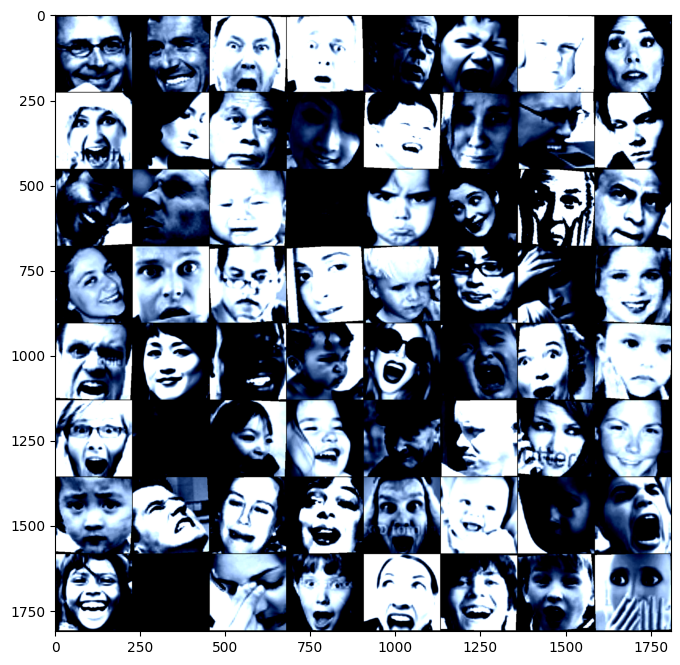

In [138]:
def imshow(img):
    plt.figure(figsize=(20,8))
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images = next(dataiter)
imshow(torchvision.utils.make_grid(images[0]))

In [139]:
#resnet = torchvision.models.resnet50(weights = torchvision.models.ResNet50_Weights.DEFAULT)
resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 184MB/s]


In [140]:
#resnet

In [141]:
# substituímos a última camada da rede para resolver o nosso problema de classificação
num_classes = len(base_dataset.classes)          # deve dar 5
in_features = resnet.fc.in_features              # em vez de "chutar" 2048

#resnet.fc = nn.Linear(in_features, num_classes)

resnet.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(in_features, num_classes)
)

resnet = resnet.to(device)

In [142]:
#  resnet

In [143]:
# "congelamos os pesos das camadas, exceto a última"
for name, params in resnet.named_parameters():
    params.requires_grad = False

for name, params in resnet.named_parameters():
    if name.startswith("layer4") or name.startswith("fc"):
        params.requires_grad = True


In [144]:
# conta quantos exemplos tem de cada classe NO TREINO
train_labels = []
for i in range(len(small_train_subset)):
    _, label = small_train_subset[i]   # (PIL_image, label)
    train_labels.append(label)

counts = Counter(train_labels)
print("Contagem por classe no treino (debug):", counts)

num_classes = len(base_dataset.classes)

# cria pesos inversamente proporcionais à frequência
class_weights = torch.zeros(num_classes, dtype=torch.float)
for cls in range(num_classes):
    class_weights[cls] = 1.0 / counts[cls]

# manda pesos pra GPU/CPU correta
class_weights = class_weights.to(device)

class_weights = class_weights / class_weights.mean()
print("Pesos por classe:", class_weights)

Contagem por classe no treino (debug): Counter({2: 1595, 3: 1039, 0: 905, 1: 766, 4: 695})
Pesos por classe: tensor([1.0158, 1.2002, 0.5764, 0.8848, 1.3228], device='cuda:0')


In [145]:
resnet.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, resnet.parameters()),
    lr=1e-4,              # menor porque agora mexe em conv também
    weight_decay=1e-4     # L2 leve (ajuda a segurar overfitting)
)

scheduler = ReduceLROnPlateau(
    optimizer,
    mode="min",     # minimizar a val_loss
    factor=0.5,     # divide o LR por 2 quando não melhorar
    patience=2      # espera 2 épocas sem melhora
)

epochs = 20


In [146]:
#train(resnet, trainloader, testloader, optimizer, criterion, epochs)

train(
    resnet,
    trainloader,
    testloader,
    optimizer,
    criterion,
    epochs,
    scheduler=scheduler,
    early_stopping_patience=5  # para se passar 5 épocas sem melhorar
)

100%|██████████| 79/79 [00:39<00:00,  2.02it/s]


Epoch: 1 | Train Loss: 1.4591 | Val Loss: 1.1801 | LR: 0.000100


100%|██████████| 79/79 [00:39<00:00,  2.02it/s]


Epoch: 2 | Train Loss: 1.1202 | Val Loss: 1.0701 | LR: 0.000100


100%|██████████| 79/79 [00:39<00:00,  2.02it/s]


Epoch: 3 | Train Loss: 0.9598 | Val Loss: 1.0112 | LR: 0.000100


100%|██████████| 79/79 [00:39<00:00,  1.99it/s]


Epoch: 4 | Train Loss: 0.8230 | Val Loss: 1.0183 | LR: 0.000100


100%|██████████| 79/79 [00:39<00:00,  1.99it/s]


Epoch: 5 | Train Loss: 0.7213 | Val Loss: 1.0016 | LR: 0.000100


100%|██████████| 79/79 [00:40<00:00,  1.97it/s]


Epoch: 6 | Train Loss: 0.6191 | Val Loss: 1.0899 | LR: 0.000100


100%|██████████| 79/79 [00:39<00:00,  1.99it/s]


Epoch: 7 | Train Loss: 0.5265 | Val Loss: 1.0597 | LR: 0.000100


100%|██████████| 79/79 [00:39<00:00,  2.00it/s]


Epoch: 8 | Train Loss: 0.4342 | Val Loss: 1.1501 | LR: 0.000050


100%|██████████| 79/79 [00:39<00:00,  2.00it/s]


Epoch: 9 | Train Loss: 0.3652 | Val Loss: 1.0916 | LR: 0.000050


100%|██████████| 79/79 [00:38<00:00,  2.03it/s]


Early stopping na época 10. Melhor val_loss: 1.0016


A rede atinge: 65.4% de acurácia


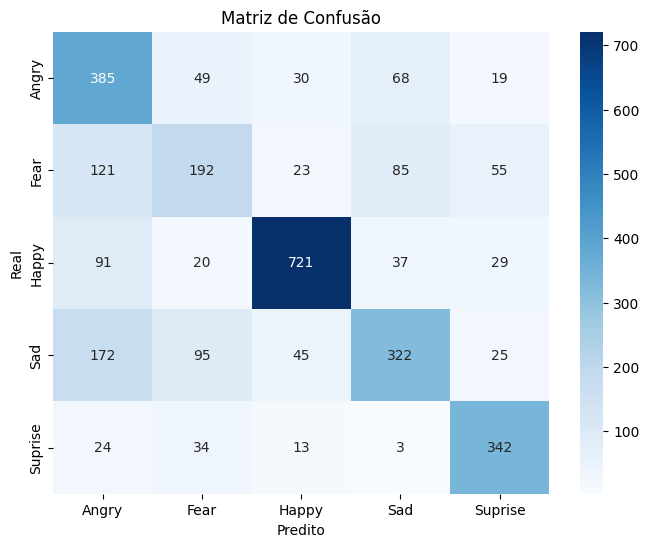

In [147]:
print(f'A rede atinge: {accuracy(resnet, testloader)}% de acurácia')
conf_mat = confusion_matrix(resnet, testloader)